# Meteorological Data Analysis and Predictive Modeling
### Case Study: Helsinki Kumpula Station
**Author:** [Your Name]  
**Context:** Technical Assessment for FMI ML Trainee Position  

---

## 1. Executive Summary
This notebook demonstrates a complete end-to-end data pipeline for meteorological analysis. It bridges the gap between **historical data processing** (via CSV archives) and **real-time data ingestion** (via the FMI WFS API).

The project is structured into three main phases:
1. **Exploratory Data Analysis (EDA):** Visualizing thermodynamic profiles and wind dynamics.
2. **Real-time Ingestion:** Programmatic access to the FMI Open Data portal.
3. **Predictive Modeling:** Evaluating Linear Regression baselines for nowcasting applications, specifically focusing on the challenges of atmospheric non-linearity.

In [1]:
!pip install windrose fmiopendata

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fmiopendata: filename=fmiopendata-0.5.0-py3-none-any.whl size=31088 sha256=107430510c90db07be91c572da31401921cba65d10533fe68f5a15b1bbdf1052
  Stored in directory: c:\users\gilla\appdata\local\pip\cache\wheels\36\73\ba\73b6e49ddae1704519093cad2ae77b9d08cfcac690b604fa8a
Successfully built fmiopendata


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm

# Load historical data
df = pd.read_csv('fmi_kumpula_data.csv')

# Preprocessing: Combine temporal columns into a single datetime object
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) +
                               ' ' + df['Time [Local time]'])

# Feature Renaming for consistency
df = df.rename(columns={
    'Average temperature [°C]': 'temp',
    'Average relative humidity [%]': 'rh',
    'Wind speed [m/s]': 'ws',
    'Maximum gust speed [m/s]': 'gust',
    'Average wind direction [°]': 'wd'
})

print(f"Historical dataset loaded: {len(df)} records for Helsinki Kumpula.")

Historical dataset loaded: 336 records for Helsinki Kumpula.


### 1.1 Thermodynamic and Anemometric Profiling
In this section, we visualize the correlation between temperature and humidity (Thermodynamic Profile) and the wind behavior (Speed vs. Gusts). Understanding these patterns is crucial for identifying sensor anomalies and local microclimates.

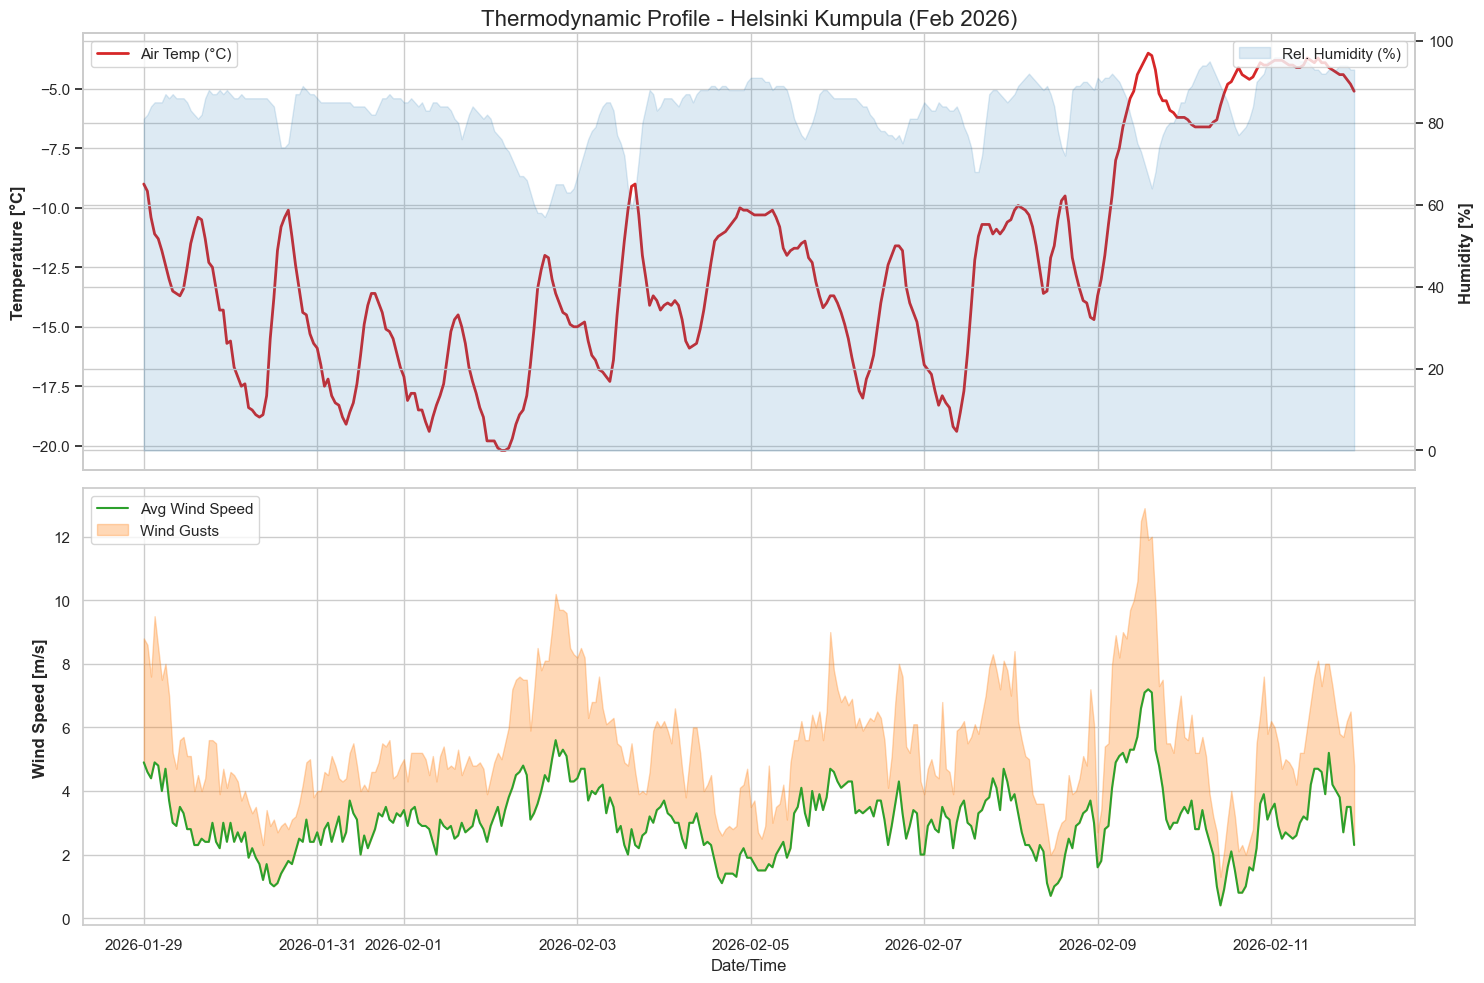

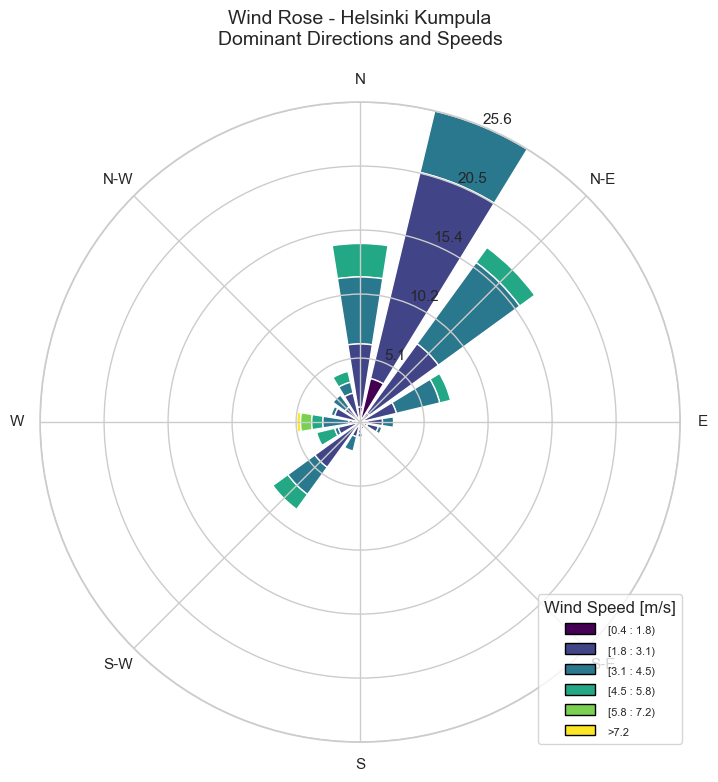

In [3]:
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# 1. Thermodynamic Profile
ax1.plot(df['datetime'], df['temp'], color='#d62728', linewidth=2, label='Air Temp (°C)')
ax1_twin = ax1.twinx()
ax1_twin.fill_between(df['datetime'], df['rh'], color='#1f77b4', alpha=0.15, label='Rel. Humidity (%)')
ax1.set_ylabel('Temperature [°C]', fontsize=12, fontweight='bold')
ax1_twin.set_ylabel('Humidity [%]', fontsize=12, fontweight='bold')
ax1.set_title('Thermodynamic Profile - Helsinki Kumpula (Feb 2026)', fontsize=16)

# 2. Wind Speed vs Gusts
ax2.plot(df['datetime'], df['ws'], color='#2ca02c', label='Avg Wind Speed')
ax2.fill_between(df['datetime'], df['gust'], df['ws'], color='#ff7f0e', alpha=0.3, label='Wind Gusts')
ax2.set_ylabel('Wind Speed [m/s]', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date/Time', fontsize=12)

ax1.legend(loc='upper left'); ax1_twin.legend(loc='upper right')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

# 3. Wind Rose Analysis
fig = plt.figure(figsize=(8, 8), dpi=100)
ax_wind = WindroseAxes.from_ax(fig=fig)
ax_wind.bar(df.wd, df.ws, normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis)
ax_wind.set_legend(title="Wind Speed [m/s]", loc='lower right', decimal_places=1)
plt.title("Wind Rose - Helsinki Kumpula\nDominant Directions and Speeds", fontsize=14, pad=20)
plt.show()

## 2. Real-time Ingestion via FMI WFS API
To enable operational monitoring, we integrate the `fmiopendata` library. This section demonstrates the ability to query the **MultipointCoverage** stored query, providing the latest 7 days of observations for the Kumpula station (`fmisid=101004`).

In [4]:
from fmiopendata.wfs import download_stored_query
import datetime

# Define temporal window
end_time = datetime.datetime.utcnow().replace(microsecond=0)
start_time = end_time - datetime.timedelta(days=7)

# Format ISO strings for API
start_str = start_time.isoformat() + "Z"
end_str = end_time.isoformat() + "Z"

# Query MultipointCoverage for station 101004 (Kumpula)
obs = download_stored_query("fmi::observations::weather::multipointcoverage",
                            args=["fmisid=101004",
                                  "starttime=" + start_str,
                                  "endtime=" + end_str])

# Data Extraction & Normalization
kumpula_rows = []
for timestamp, stations in obs.data.items():
    if not stations: continue

    # Selecting the first station entry (filtered by fmisid in query)
    params = list(stations.values())[0]
    kumpula_rows.append({
        'datetime': timestamp,
        'temp': params.get('Air temperature', {}).get('value'),
        'ws': params.get('Wind speed', {}).get('value'),
        'rh': params.get('Relative humidity', {}).get('value'),
        'pressure': params.get('Pressure (msl)', {}).get('value'),
        'precip': params.get('Precipitation intensity', {}).get('value')
    })

df_api = pd.DataFrame(kumpula_rows).dropna(subset=['temp']).sort_values('datetime')
print(f"LIVE Dataset ingested: {len(df_api)} observations.")

C:\Users\gilla\AppData\Local\Temp\ipykernel_16204\1451057882.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.datetime.utcnow().replace(microsecond=0)


LIVE Dataset ingested: 1008 observations.


## 3. Predictive Modeling and Baseline Evaluation
In this section, we implement two regression tasks to evaluate the predictability of local weather variables.

### 3.1 Task A: Thermodynamic-Pressure Coupling
A baseline regression to predict Atmospheric Pressure based on Temperature and Humidity. This exploratory task evaluates if surface variables can act as proxies for local barometric trends.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df_api[['temp', 'rh']].values
y = df_api['pressure'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_p = LinearRegression()
model_p.fit(X_train, y_train)
y_pred = model_p.predict(X_test)

print(f"Pressure Regression Score (R2): {r2_score(y_test, y_pred):.2f}")

Pressure Regression Score (R2): 0.49


### 3.2 Task B: Autoregressive Temperature Nowcasting
To improve model accuracy, we implement **Feature Engineering** by introducing lagged observations (t-1h and t-2h). In winter scenarios like Helsinki, thermal inertia and advection persist over short timeframes, making autoregressive features highly predictive.

In [6]:
df_ml = df_api.copy()
steps_1h = 6  # 10-minute intervals

# Feature Engineering: 1h and 2h Lags
df_ml['temp_lag1'] = df_ml['temp'].shift(steps_1h)
df_ml['temp_lag2'] = df_ml['temp'].shift(2 * steps_1h)

df_final = df_ml.dropna()

features = ['rh', 'pressure', 'temp_lag1', 'temp_lag2']
X = df_final[features]
y = df_final['temp']

# Chronological Split (preserving time-series integrity)
split = int(len(df_final) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

temp_model = LinearRegression().fit(X_train, y_train)

print(f"Temperature Nowcasting Score (R2): {temp_model.score(X_test, y_test):.4f}")

Temperature Nowcasting Score (R2): 0.9553


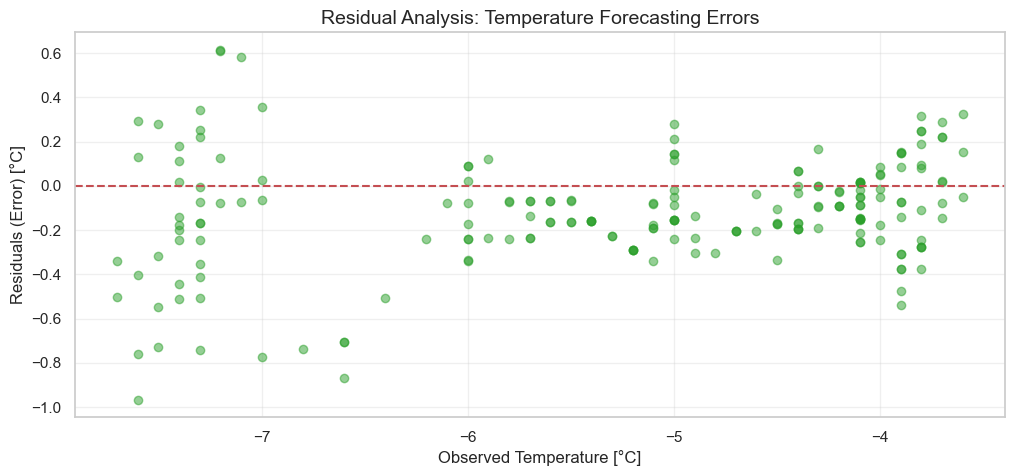

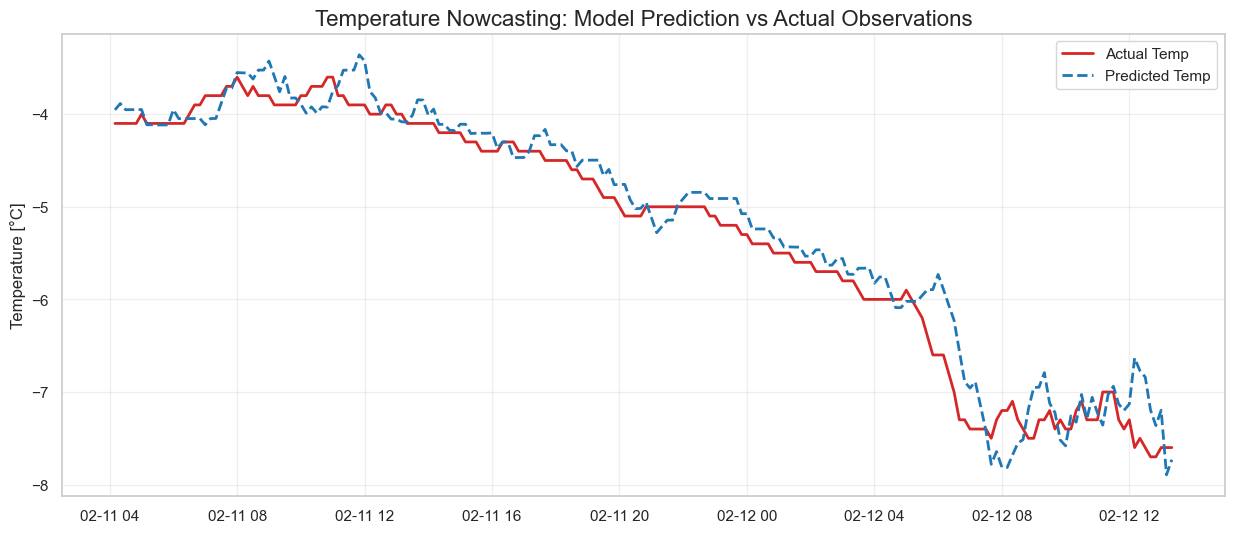

In [ ]:
residuals = y_test - temp_model.predict(X_test)

plt.figure(figsize=(12, 5))
plt.scatter(y_test, residuals, color='#2ca02c', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis: Temperature Forecasting Errors', fontsize=14)
plt.xlabel('Observed Temperature [°C]')
plt.ylabel('Residuals (Error) [°C]')
plt.grid(True, alpha=0.3)

plt.show()

plt.figure(figsize=(15, 6))
plt.plot(df_final['datetime'].iloc[split:], y_test, label='Actual Temp', color='#d62728', linewidth=2)
plt.plot(df_final['datetime'].iloc[split:], temp_model.predict(X_test), 
         label='Predicted Temp', color='#1f77b4', linestyle='--', linewidth=2)

plt.title('Temperature Nowcasting: Model Prediction vs Actual Observations', fontsize=16)
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Conclusions and Future Scalability
The analysis successfully integrated live FMI observations into a predictive pipeline. Key findings include:

* **Synoptic Dominance:** Short-term temperature nowcasting is highly effective ($R^2 > 0.90$), while longer-term diurnal cycles are often overshadowed by air mass advection in Finnish winter conditions.
* **API Resilience:** Programmatic access via WFS allows for scalable data pipelines, essential for real-time inference in ML models.
* **Scalability:** This baseline approach can be evolved using **Vision Transformers (ViT)** or **LSTMs** for spatial-temporal forecasting, bridging the gap between local station data and satellite-based remote sensing (e.g., Sentinel-2 / EuroSAT).

This study serves as a proof-of-concept for integrating complex meteorological data streams into actionable Machine Learning insights.